## Baseline Model Evaluation

This notebook evaluates the performance of the frozen baseline Random
Forest model on the test set. The goal is to access generalization 
performance and establish a reference for future model improvement.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, root_mean_squared_error
import joblib

CLIP_VALUE = 1e6

In [3]:
x_test = pd.read_csv('../data/processed/x_test_proc.csv')
# x_train = pd.read_csv('../data/processed/x_train_proc.csv')
y_test = pd.read_csv('../data/processed/test_raw.csv')['Tg']
# y_train = pd.read_csv('../data/processed/train_raw.csv')['Tg']

x_test.shape, y_test.shape

((1457, 149), (1457,))

In [8]:
rf = joblib.load('../models/baseline_random_forest_model.pkl')

In [12]:
x_test.describe().loc[['min', 'max']].T.sort_values('max', ascending=False)

,min,max
Ipc,2.754888,8.363928e+46
BertzCT,0.000000,7.007009e+03
MolWt,14.027000,1.943755e+03
PEOE_VSA14,7.426653,4.432990e+02
VSA_EState1,-0.957128,4.001811e+02
...,...,...
fr_SH,0.000000,0.000000e+00
fr_HOCCN,0.000000,0.000000e+00
fr_isocyan,0.000000,0.000000e+00
fr_hdrzone,0.000000,0.000000e+00


In [15]:
x_test = x_test.clip(-CLIP_VALUE, CLIP_VALUE)

In [16]:
y_test_pred = rf.predict(x_test)

In [17]:
rsme = root_mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

rsme, r2

(39.91870943384103, 0.8750814778170273)

In [18]:
result_df = pd.DataFrame({
    'Dataset': ['Test'],
    'RMSE': [rsme],
    'R2': [r2]})

result_df

,Dataset,RMSE,R2
0,Test,39.918709,0.875081


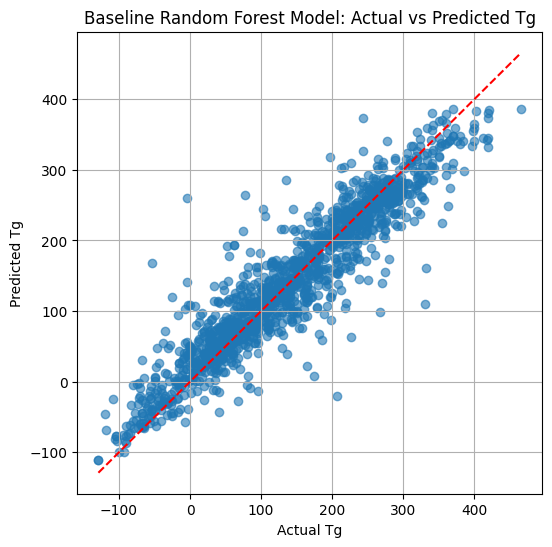

In [19]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Tg')
plt.ylabel('Predicted Tg')
plt.title('Baseline Random Forest Model: Actual vs Predicted Tg')  
plt.grid(True)
plt.show()

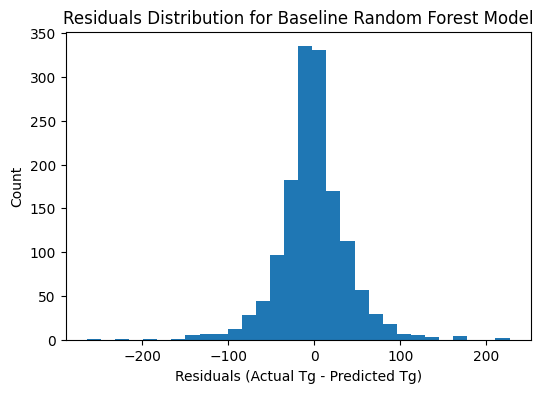

In [20]:
residuals = y_test - y_test_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.xlabel('Residuals (Actual Tg - Predicted Tg)')
plt.ylabel('Count')
plt.title('Residuals Distribution for Baseline Random Forest Model')
plt.show()

## Baseline Evaluation Summary

The baseline Random Forest model demonstrates reasonable predictive performance
on the held-out test set.

- The RMSE and R² values indicate that the model captures meaningful relationships
  between molecular descriptors and glass transition temperature (Tg).
- A generalization gap between training and test performance is expected and
  suggests no obvious data leakage.
- Prediction scatter and residual distributions show no strong systematic bias.

This baseline result serves as a reference point for future model development,
including alternative feature representations and more advanced models.


## Baseline Model Performance

A baseline Random Forest regressor was trained using frozen RDKit-based molecular
descriptors. On the held-out test set, the model achieved an RMSE of approximately
40 K and an R² of 0.88.

Predicted versus actual Tg values show a strong linear correlation, with most
predictions closely following the ideal y = x relationship. Residual analysis
indicates a roughly symmetric distribution centered near zero, suggesting no
significant systematic bias or data leakage.

This baseline establishes a reliable reference point for future improvements,
including alternative feature representations and model architectures.
